### Google Mount

In [ ]:
!rm -r sample_data

from google.colab import drive
drive.mount('/content/drive')

rm: cannot remove 'sample_data': No such file or directory
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries, models

In [ ]:
!pip install tensorflow_text

import gensim.downloader
import re
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.initializers import Constant
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Load & Exploration

In [ ]:
# Make change based on the folder structure your dataset files are at
BASE_DIR = os.path.join(os.getcwd(), 'drive/MyDrive/NLP/DeepLearning Course')
PATH_TRAIN = os.path.join(BASE_DIR, 'train.csv')
PATH_TEST = os.path.join(BASE_DIR, 'test.csv')

df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [ ]:
# first five instances
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# column information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# target distribution
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Balancing the dataset

In [ ]:
# Undersampling technique, a few entries of label 0 will be dropped since it is a majority class
df_0_class = df_train[df_train['target']==0]
df_1_class = df_train[df_train['target']==1]
df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
df_train = pd.concat([df_0_class_undersampled, df_1_class], axis=0)

### Text Cleaning & Preprocessing

In [ ]:
def clean_text(text):
    # Proprocessing the data
    text = text.lower()
    # Remove RT:
    text = re.sub(r'(rt)([:]*) \S+:', '', text)
    # Remove emoticons
    text = re.sub(r'\s+(\:\)|\:\(|<3|\:\/|\:-\/|\:\||\:p)\s', '', text)
    # Remove url
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(regex, '', text)
    # Remove html entities
    text = re.sub(r"&(nbsp|amp|quot|lt|gt|copy);", '', text)
    # Code to remove the Hash from the text
    text = re.sub(r'(\B#)(\S+)',r'\2', text)
    # Remove 'at @'
    text = re.sub(r'@([A-Za-z0-9_]+)', '', text)
    # Remove special characters-1
    text = re.sub(r"([a-z']+)([^a-z' ]+)([a-z']+)", r"\1 \3", text)
    text = re.sub(r"[^a-z' ]", "", text)
    # Trim and remove sequential spaces
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

In [ ]:
def decontration(text):
    #below contractons are specific to words and cannot be solved by general solution
    text = re.sub(r"aren't", 'are not', text)
    text = re.sub(r"won't", 'will not', text)
    text = re.sub(r"doesn't", 'does not', text)
    #Below contractions are general and works for most of the word
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text.lower()

In [ ]:
# Tokenize
def tokenize(text):
  return word_tokenize(text)

In [ ]:
# Remove stop words
stop_words = set(stopwords.words('english')) 
def remove_stop_words(tokens):
  return [token for token in tokens if not token in stop_words]

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
  return [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
# Preprocess
def clean_preprocess(text):
  if text != np.NaN:
    text = str(text)
    text = clean_text(text)
    text = decontration(text)
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    tokens = lemmatize(tokens)
    return ' '.join(tokens)

In [ ]:
# merge keyword and text columns
def process_merge(keyword, text):
  if str(keyword) != 'nan':
    return f"{clean_preprocess(keyword)} {clean_preprocess(text)}"
  return clean_preprocess(text)

In [ ]:
df_train['processed'] = df_train.apply(lambda s: process_merge(s.keyword, s.text), axis=1)
df_test['processed'] = df_test.apply(lambda s: process_merge(s.keyword, s.text), axis=1)

In [ ]:
df_train

,id,keyword,location,text,target,processed
1354,1955,burning%20buildings,a botanical garden probably,drew storen is probably curing cancer &amp; sa...,0,burning building drew storen probably curing c...
3450,4934,exploded,USA,If you told me ten years ago that I'd be seein...,0,exploded told ten year ago would seeing anime ...
1040,1506,body%20bags,NaN,I love The body shopÛªs bags??\n\n#cutekitten...,0,body bag love body shop bag cutekitten catsofi...
6049,8646,sinkhole,Trinidad and Tobago,nothing surprises me anymore and i am sure the...,0,sinkhole nothing surprise anymore sure come
6112,8726,sinking,HOMRA.,In your eyes I see the hope\nI once knew.\nI'm...,0,sinking eye see hope knew sinking sinking away...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse nearby...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california even northern par...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc km volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating e bike collided car littl...


### Feature Extraction

In [ ]:
train_texts = list(df_train['processed'])
test_texts = list(df_test['processed'])
targets = list(df_train['target'])

In [ ]:
TOP_K = 3000
MAX_SEQUENCE_LENGTH = 200
batch_size = 256

In [ ]:
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_texts)
X = tokenizer.texts_to_sequences(train_texts)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = np.array(targets)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

In [ ]:
def input_fn(X: np.ndarray, y: np.ndarray, batch_size: int,  mode: str = 'eval'):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=batch_size)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(buffer_size=batch_size)
    return dataset

In [ ]:
train_dataset = input_fn(X=X_train, y=y_train, batch_size=batch_size, mode='train')
val_dataset = input_fn(X=X_val, y=y_val, batch_size=batch_size, mode='eval')

### Build Model

In [ ]:
num_features = min(len(tokenizer.word_index) + 1, TOP_K)

In [ ]:
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [ ]:
def build_LSTM(embedding=None):
    model = Sequential()
    if embedding:
      model.add(embedding)
    else: 
      model.add(layers.Embedding(input_dim=num_features,
                            output_dim=200,
                            input_length=MAX_SEQUENCE_LENGTH))
    model.add(layers.SpatialDropout1D(0.2))
    model.add(layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimzer=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=m)
    return model

In [ ]:
model = build_LSTM()
steps_per_epoch = int(y_train.size / batch_size)*1.5
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch)

Epoch 1/10
28/28 [==============================] - 21s 656ms/step - loss: 0.6357 - accuracy: 0.6654 - precision: 0.6754 - recall: 0.6302 - val_loss: 0.5271 - val_accuracy: 0.7481 - val_precision: 0.7283 - val_recall: 0.7927
Epoch 2/10
28/28 [==============================] - 18s 642ms/step - loss: 0.4139 - accuracy: 0.8178 - precision: 0.8452 - recall: 0.7791 - val_loss: 0.4575 - val_accuracy: 0.7863 - val_precision: 0.8310 - val_recall: 0.7195
Epoch 3/10
28/28 [==============================] - 18s 638ms/step - loss: 0.3159 - accuracy: 0.8677 - precision: 0.8948 - recall: 0.8336 - val_loss: 0.5323 - val_accuracy: 0.7725 - val_precision: 0.7704 - val_recall: 0.7774
Epoch 4/10
28/28 [==============================] - 18s 643ms/step - loss: 0.2688 - accuracy: 0.8961 - precision: 0.9214 - recall: 0.8661 - val_loss: 0.5954 - val_accuracy: 0.7634 - val_precision: 0.7855 - val_recall: 0.7256
Epoch 5/10
28/28 [==============================] - 18s 641ms/step - loss: 0.2402 - accuracy: 0.9092

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 200, 200)          600000    
                                                                 
 spatial_dropout1d_13 (Spati  (None, 200, 200)         0         
 alDropout1D)                                                    
                                                                 
 lstm_15 (LSTM)              (None, 64)                67840     
                                                                 
 dense_26 (Dense)            (None, 50)                3250      
                                                                 
 dense_27 (Dense)            (None, 25)                1275      
                                                                 
 dense_28 (Dense)            (None, 1)                 26        
                                                     

### Model evaluation

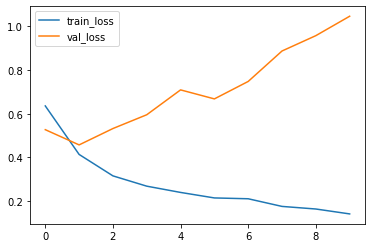

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

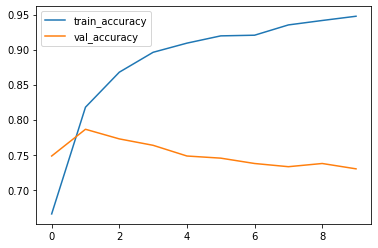

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Feature Extraction

In [ ]:
glove_twitter = gensim.downloader.load('glove-twitter-200')

In [ ]:
word_index = tokenizer.word_index
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in glove_twitter:
      emb_vec=glove_twitter[word]
      embedding_matrix[i]=emb_vec

100%|██████████| 11825/11825 [00:00<00:00, 243767.39it/s]


In [ ]:
embedding=layers.Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                input_length=200,trainable=False)
model_glove = build_LSTM(embedding)
steps_per_epoch = int(y_train.size / batch_size)*1.5
history = model_glove.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch)

Epoch 1/10
28/28 [==============================] - 20s 596ms/step - loss: 0.6314 - accuracy: 0.6437 - precision: 0.6030 - recall: 0.8278 - val_loss: 0.5151 - val_accuracy: 0.7405 - val_precision: 0.7582 - val_recall: 0.7073
Epoch 2/10
28/28 [==============================] - 16s 580ms/step - loss: 0.4916 - accuracy: 0.7699 - precision: 0.7844 - recall: 0.7447 - val_loss: 0.4734 - val_accuracy: 0.7649 - val_precision: 0.7636 - val_recall: 0.7683
Epoch 3/10
28/28 [==============================] - 16s 573ms/step - loss: 0.4556 - accuracy: 0.7883 - precision: 0.8104 - recall: 0.7528 - val_loss: 0.4605 - val_accuracy: 0.7817 - val_precision: 0.8033 - val_recall: 0.7470
Epoch 4/10
28/28 [==============================] - 16s 572ms/step - loss: 0.4357 - accuracy: 0.8024 - precision: 0.8261 - recall: 0.7668 - val_loss: 0.4604 - val_accuracy: 0.7832 - val_precision: 0.8039 - val_recall: 0.7500
Epoch 5/10
28/28 [==============================] - 16s 558ms/step - loss: 0.4313 - accuracy: 0.8032

In [ ]:
model_glove.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 200, 200)          2365200   
                                                                 
 spatial_dropout1d_14 (Spati  (None, 200, 200)         0         
 alDropout1D)                                                    
                                                                 
 lstm_16 (LSTM)              (None, 64)                67840     
                                                                 
 dense_29 (Dense)            (None, 50)                3250      
                                                                 
 dense_30 (Dense)            (None, 25)                1275      
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                     

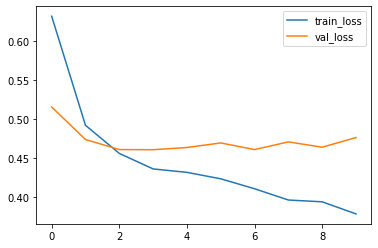

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

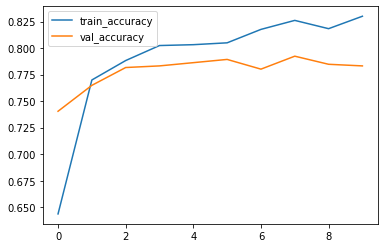

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### State-of-the-art Model - BERT

In [ ]:
#download the BERT preprocessor and encoder
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#Using BERT layers (the first three) followed by the neural network layer. 
#Included a dropout layer and eventually, the output layer will classify whether the given text is disaster news or not.
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)
d_layer = tf.keras.layers.Dropout(0.1, name="dropout-layer")(outputs['pooled_output'])
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model_bert = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

In [ ]:
model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=m)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train['processed'], df_train['target'], stratify=df_train['target'])

In [ ]:
history_bert = model_bert.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
154/154 [==============================] - 54s 287ms/step - loss: 0.6671 - accuracy: 0.6170 - precision: 0.6194 - recall: 0.6073 - val_loss: 0.6139 - val_accuracy: 0.6932 - val_precision: 0.7651 - val_recall: 0.5575
Epoch 2/10
154/154 [==============================] - 43s 279ms/step - loss: 0.6059 - accuracy: 0.6863 - precision: 0.6928 - recall: 0.6694 - val_loss: 0.5837 - val_accuracy: 0.7200 - val_precision: 0.6883 - val_recall: 0.8044
Epoch 3/10
154/154 [==============================] - 43s 280ms/step - loss: 0.5801 - accuracy: 0.7053 - precision: 0.7133 - recall: 0.6865 - val_loss: 0.5653 - val_accuracy: 0.7280 - val_precision: 0.7984 - val_recall: 0.6100
Epoch 4/10
154/154 [==============================] - 43s 280ms/step - loss: 0.5602 - accuracy: 0.7256 - precision: 0.7377 - recall: 0.7004 - val_loss: 0.5503 - val_accuracy: 0.7414 - val_precision: 0.7842 - val_recall: 0.6663
Epoch 5/10
154/154 [==============================] - 43s 278ms/step - loss: 0.5532 - accura

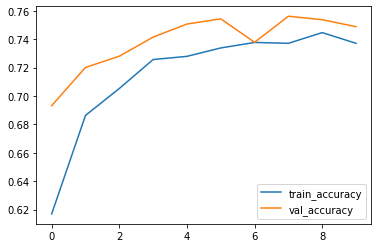

In [ ]:
plt.plot(history_bert.history['accuracy'], label='train_accuracy')
plt.plot(history_bert.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()